In [3]:
import os
import sys
import copy
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.append('../../installables/Doubly-Stochastic-DGP/')
sys.path.append('/home/daniel/data/DGP_DATA/C2X/')
from doubly_stochastic_dgp.dgp import DGP
from scipy.cluster.vq import kmeans2
from scipy.io import loadmat
from gpflow.likelihoods import Gaussian
from gpflow.kernels import RBF, White, Constant
from gpflow.mean_functions import Constant
from gpflow.models.sgpr import SGPR, GPRFITC
from gpflow.models.svgp import SVGP
from gpflow.models.gpr import GPR
from gpflow.training import AdamOptimizer, ScipyOptimizer, NatGradOptimizer
from gpflow.actions import Action, Loop
from gpflow import autoflow, params_as_tensors


In [4]:
def scale_auto(X,Y):
    """
    Subtract mean and scale with std
    """
    mu_X = X.mean(axis=0); std_X = X.std(axis=0)
    mu_Y = Y.mean(axis=0); std_Y = Y.std(axis=0)
    Xscaled = (X-mu_X)/std_X
    Yscaled = (Y-mu_Y)/std_Y
    return (Xscaled, Yscaled, mu_X, mu_Y, std_X, std_Y)

def scale_manu(X,Y,mu_X, mu_Y, std_X, std_Y):
    """
    Subtract mean and scale with std
    """
    Xscaled = (X-mu_X)/std_X
    Yscaled = (Y-mu_Y)/std_Y
    return (Xscaled, Yscaled)


def make_DGP(X,Y,Z,L,nsam=1,mb=10000):
    kernels = []
    d = X.shape[1]
    
    k = RBF(d) #+ White(1., variance=1e-5)
    kernels.append(k)
    
    hidden=5
    for l in range(1,L):
        k = RBF(hidden) # + White(1., variance=1e-5)
        kernels.append(k)
        
    m_dgp = DGP(X, Y, Z, kernels, Gaussian(), num_samples=nsam, minibatch_size=mb)
    
    for layer in m_dgp.layers[:-1]:
        layer.q_sqrt = layer.q_sqrt.value * 1e-5
    return m_dgp

def dgp_batchpred(dgp,Xts,bsize,VAR=False):
    M = Xts.shape[0]
    batches = int(np.round(M/bsize))
    starts = [n*bsize for n in range(batches)]
    ends = starts[1:] + [M-1]
    pred = np.zeros([M,1])
    var = np.zeros([M,1])
    for start, end in zip(starts,ends):
        m,v = dgp.predict_y(Xts[start:end,:],50)
        pred[start:end,0] = np.mean(m, 0).ravel()
        var[start:end,0] = np.mean(v, 0).ravel()
    
    if VAR:
        return(pred,var)
    else:
        return(pred)

### Get data

In [5]:
BIOPHYS = pd.read_csv('/home/daniel/data/DGP_DATA/C2X/C2X_ONNSv04_HL_20151110_Rrs_fn_OLCI.txt', delimiter='\s+')
OLCI = pd.read_csv('/home/daniel/data/DGP_DATA/C2X/HL_20151110_Rrs_fn_realOLCIbands.txt', delimiter='\s+')
cases = ['C1' for i in range(20000)] + ['C2A' for i in range(20000)] + ['C2S' for i in range(20000)] + ['C2AX' for i in range(20000)] + ['C2SX' for i in range(20000)] 
BIOPHYS['Case'] = cases

In [6]:
# Clean for NaNs
nans = BIOPHYS.isna().any(1)
BIOPHYS = BIOPHYS[~nans]
OLCI = OLCI[~nans]
N = OLCI.shape[0]

### Use same train/test split as [Hieronymi et al](https://www.frontiersin.org/articles/10.3389/fmars.2017.00140/full)

In [7]:
# Extract indices
itest = pd.read_csv('/home/daniel/data/DGP_DATA/C2X/P_IDs_Not_used_for_NN_training.dat', sep='\n', header=None).values.ravel() - 1 
itrain = np.array([i for i in range(0,N) if i not in itest])

# To boolean
booltrain = OLCI.index.isin(itrain)
booltest = OLCI.index.isin(itest)

### Chose Hieronymi et al's bands and scale data

In [8]:
martinbands = [0,1,2,3,4,5,6,7,11,15,16]
X = OLCI.values[:,1:] # Unselect simulation index
X = X[:,martinbands] # Select same bands as used to train ONNS
Y = BIOPHYS['CDOM'].values.reshape([-1,1])
Xscaled, Yscaled, mu_X, mu_Y, std_X, std_Y = scale_auto(X,Y)

In [9]:
Xtr = Xscaled[booltrain]
Xts = Xscaled[booltest]
Ytr = Yscaled[booltrain]
Yts = Yscaled[booltest]
testcase = BIOPHYS['Case'].values.reshape([-1,1])[booltest].ravel().tolist()

In [10]:
Z = kmeans2(Xtr, 500, minit='points')[0]

In [11]:
# define DGP
ultra_dgp = make_DGP(Xtr,Ytr,Z,3)
RMSE = []

# fix inducing points
dgp_inducings = [[ultra_dgp.layers[0].feature,ultra_dgp.layers[1].feature,ultra_dgp.layers[2].feature]]
for v in dgp_inducings[0]:
    v.set_trainable(False)
    
AdamOptimizer(0.01).minimize(ultra_dgp, maxiter=2000)

11 5
5 5


In [12]:
# optimize inducing
for v in dgp_inducings[0]:
    v.set_trainable(True)

In [13]:
AdamOptimizer(0.01).minimize(ultra_dgp, maxiter=10000)
AdamOptimizer(0.001).minimize(ultra_dgp, maxiter=10000)

In [14]:
pred_test,var_test = dgp_batchpred(ultra_dgp,Xts,100,VAR=True)

rmse is  [0.09207479]


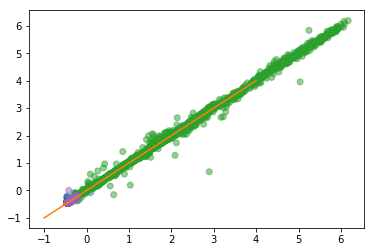

In [127]:
pred = pred_test
two_std = 2*np.sqrt(var_test)
colordict = {'C1':'C0', 'C2A':'C1', 'C2AX':'C2', 'C2S':'C3', 'C2SX':'C4'}
plt.scatter(Yts,pred,color = [colordict[case] for case in testcase],alpha=0.5)
print('rmse is ', std_Y * np.sqrt(np.mean( (pred-Yts)**2 )) )
plt.plot([-1,4],[-1,4],color='C1')

In [128]:
NNrmse = {'C1':0.0174, 'C2A':0.0234, 'C2AX':0.4356, 'C2S':0.0290, 'C2SX':0.0971}
Ntot = 0
SEtot = 0
for case in set(testcase):
    ind = np.array(testcase)==case
    Nsub = sum(ind)
    Ntot += Nsub    
    SEsub = ( NNrmse[case]**2 )*Nsub
    SEtot += SEsub
rmse = np.sqrt(SEtot/Ntot)
print('All-around RMSE of ONSS is', rmse)

All-around RMSE of ONSS is 0.2019761796051002


In [129]:
cases = ['C1', 'C2A', 'C2AX', 'C2S', 'C2SX']

rmse is for case  C1  is 0.028240150238951933 , compare to rmse for ONNS:  0.0174
rmse is for case  C2AX  is 0.1997532757218914 , compare to rmse for ONNS:  0.4356
rmse is for case  C2S  is 0.01452998509813487 , compare to rmse for ONNS:  0.029
rmse is for case  C2SX  is 0.02604412064119329 , compare to rmse for ONNS:  0.0971
rmse is for case  C2A  is 0.017861013038306253 , compare to rmse for ONNS:  0.0234


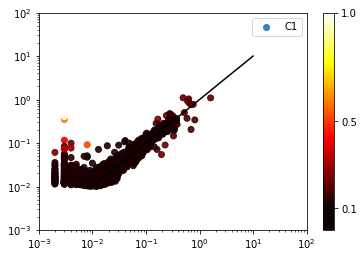

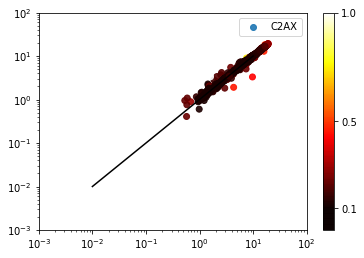

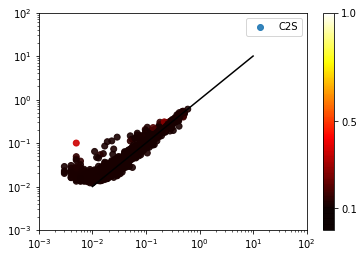

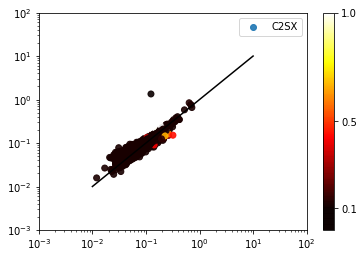

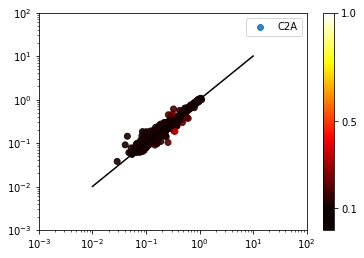

In [124]:
cm = plt.cm.get_cmap('hot')
NNrmse = {'C1':0.0174, 'C2A':0.0234, 'C2AX':0.4356, 'C2S':0.0290, 'C2SX':0.0971}
backtrans_pred = (pred*std_Y)+mu_Y
backtrans_two_std = two_std*std_Y
backtrans_Yts = (Yts*std_Y)+mu_Y
for case in set(testcase):
    ind = np.array(testcase)==case
    print('rmse is for case ',case,' is', np.sqrt(np.mean( (backtrans_pred[ind]-backtrans_Yts[ind])**2 )),', compare to rmse for ONNS: ', NNrmse[case] )
    plt.figure()
    sc = plt.scatter(backtrans_Yts[ind],backtrans_pred[ind],c=backtrans_two_std[ind],label=case,cmap=cm,vmin=0,vmax=1,alpha=0.9)
    cb = plt.colorbar(sc); cb.set_clim([0.1,1]); cb.set_ticks([0.1,0.5,1])
    plt.plot([1e-2,1e1],[1e-2,1e1],color='k')
    plt.xscale('log'); plt.yscale('log')
    plt.xlim([1e-3,1e2]); plt.ylim([1e-3,1e2])
    plt.legend()